_version log: Merging V41 and V42 as well as creating nice plots for poster._

In [35]:
import FTIR_functions as FTIR
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import interpolate as spinter

In [36]:
###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA##################

manta_data = FTIR.import_normalised_csv("mantra_spectrum.csv", 0)
manta_data[:,0] = FTIR.recip(manta_data[:,0]*1e-3) #convert nm to THz
manta_function = spinter.interp1d(manta_data[:,0], manta_data[:,1], fill_value= np.nan, bounds_error= False)

purple_data = FTIR.import_normalised_csv("PV320_spectrum.csv", 0)
purple_data[:,0] = FTIR.recip(purple_data[:,0]*1e-3) #convert nm to THz
purple_function = spinter.interp1d(purple_data[:,0], purple_data[:,1], fill_value= np.nan, bounds_error= False)

ir_data = FTIR.import_normalised_csv("SLS201L_spectrum.csv", 1)
ir_data[:,0] = FTIR.recip(ir_data[:,0]*1e-3) #convert nm to THz
ir_function = spinter.interp1d(ir_data[:,0], ir_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

big_data = FTIR.import_normalised_csv("SLS303_spectrum.csv", 1)
big_data[:,0] = FTIR.recip(big_data[:,0]*1e-3) #convert nm to THz
big_function = spinter.interp1d(big_data[:,0], big_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

def camera_function(x, camera):
        return (manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))


def manufacturers_function(x, source, camera):
        return (ir_function(x)**(source == "ir") * #source_function if true, 1 if false. I'm kinda proud of this. I think it's a neat solution.
                big_function(x)**(source == "big") *
                manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))

def spectral_responce_normalisation(amplitude, frequencies, source, camera):
        percentagediff = (manufacturers_function(frequencies[:-1], source, camera) - amplitude[:-1]) /amplitude[:-1]
        amplitude *= np.nanpercentile(percentagediff[percentagediff != -1], 10) +1 #re-scale to fit

        normalised_amplitude = amplitude / camera_function(frequencies, camera) #factor in the camera sensitivity
        return normalised_amplitude

In [37]:
################MAIN###################

def process_data(source, run, camera, file_type, delay_line_delta= 2, zero_padding= 1):

    if camera == "manta":
        pixel_pitch = 9.9 #um
    elif camera == "xeva":
        pixel_pitch = 20 #um
    elif camera == "purple":
        pixel_pitch = 48.5 #um
    elif camera == "pyro":
        pixel_pitch = 80 #um
    else:
        raise ValueError(camera + " is not a valid camera.")

    fringes, beamA, beamB, background = FTIR.import_standard_photo(source, run, file_type)
    fringes_processed, nofringes = FTIR.bg_subtract(fringes, beamA, beamB, background, dead_pixels= 0.1)
    fringes_averaged, maximums, maximums_offsets = FTIR.average_interferogram(fringes_processed)
    reference, reference_processed, reference_averaged, reference_offset, reference_nofringes = FTIR.pick_centered_interferogram(maximums_offsets, fringes, fringes_processed, fringes_averaged, nofringes, maximums)
    reference_maximum, _ = FTIR.estimate_best_S2N(reference_averaged)
    reference_sliced, _, _, _ = FTIR.FFT2D_slice_interferogram(reference_processed, pixel_pitch)
    reference_zeropadded = FTIR.zero_pad(reference_sliced, zero_padding)
    reference_apodized = FTIR.apodization(reference_zeropadded, reference_maximum, function= ["blackmann-harris"], L= len(reference_sliced), zero_padding= zero_padding)
    theta = FTIR.delay_line_angle(fringes_averaged, maximums, delay_line_delta, pixel_pitch, delay_line_bounds= [2,-1])
    print(np.rad2deg(theta)*60)
    amplitude, corrected_wavelengths, corrected_frequencys = FTIR.spectralFFT(reference_apodized, theta, pixel_pitch)
    normalised_amplitude = spectral_responce_normalisation(amplitude, corrected_frequencys, source, camera)

    return reference_processed, corrected_frequencys, normalised_amplitude, reference_sliced, reference_maximum

to_plot_purple, to_plot_purple_freqs, to_plot_purple_amps, to_plot_purple_1d, purple_maximum = process_data("big", "18", "purple", ".fts", delay_line_delta= 2, zero_padding= 4)
to_plot_xeva, to_plot_xeva_freqs, to_plot_xeva_amps, to_plot_xeva_1d, xeva_maximum = process_data("big", "13", "xeva", ".csv", delay_line_delta= 5, zero_padding= 4)


c:\Users\syf83691\OneDrive - Science and Technology Facilities Council\Documents\python\git_projects\THz-interferometry\interferometry\FTIR_functions.py:301: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["max"].interpolate(inplace=True)
c:\Users\syf83691\OneDrive - Science and Technology Facilities Council\Documents\python\git_projects\THz-interferometry\interferometry\FTIR_functions.py:304: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The 

4.621220083663879
5.810657569711088


c:\Users\syf83691\OneDrive - Science and Technology Facilities Council\Documents\python\git_projects\THz-interferometry\interferometry\FTIR_functions.py:301: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["max"].interpolate(inplace=True)
c:\Users\syf83691\OneDrive - Science and Technology Facilities Council\Documents\python\git_projects\THz-interferometry\interferometry\FTIR_functions.py:304: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The 

In [38]:
fringes, beamA, beamB, background = FTIR.import_standard_photo("big", "23", ".csv")

fringes.shape

(320, 321, 8)

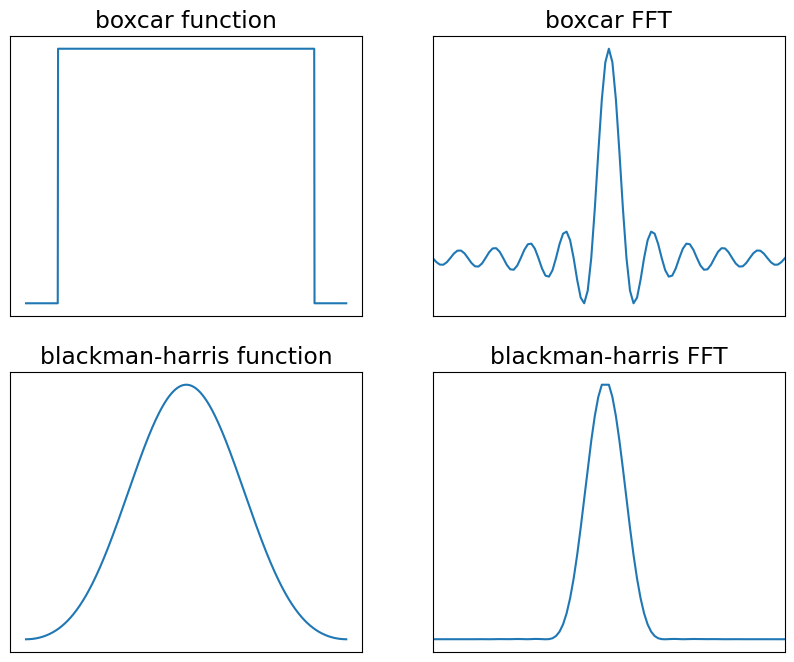

In [39]:
L = 800
zero_padding = 1000/L
boxcar = FTIR.apodization(function= ["box"], L= L, zero_padding= zero_padding)
boxcar_FFT = np.fft.fftshift(-np.fft.fft(boxcar -1, norm= "forward")) #The center of the function is not at zero so the phase is shifted. I fudged it to make it look right.


blackmann_harris = FTIR.apodization(function= ["blackmann-harris"])

L = 180
zero_padding = 1000/L
blackmann_harris_FFT = FTIR.apodization(function= ["blackmann-harris"], L= L, zero_padding= zero_padding)
blackmann_harris_FFT = np.fft.fftshift(np.fft.fft(blackmann_harris_FFT, norm= "forward")[1:])
blackmann_harris_FFT_index = np.concatenate([np.arange(0,499), np.arange(500,1000)])

plt.rcParams.update({'font.size':14})
fig, axs = plt.subplots(2,2, figsize= (10,8))

axs[0][0].plot(boxcar)
axs[0][0].set_title("boxcar function")
axs[0][1].plot(np.real(boxcar_FFT))
axs[0][1].set(xlim = (450,550), title= "boxcar FFT")

axs[1][0].plot(blackmann_harris)
axs[1][0].set_title("blackman-harris function")
axs[1][1].plot(blackmann_harris_FFT_index, np.abs(blackmann_harris_FFT))
axs[1][1].set(xlim = (450,550), title= "blackman-harris FFT")

[ax.set_xticks([]) for ax in axs.flatten()]
[ax.set_yticks([]) for ax in axs.flatten()]

plt.show()

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\syf83691\OneDrive - Science and Technology Facilities Council\Documents\python\git_projects\THz-interferometry\interferometry\FTIR_functions.py:25: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa. #1e4 / x # converts um to cm^-1 or vice versa.


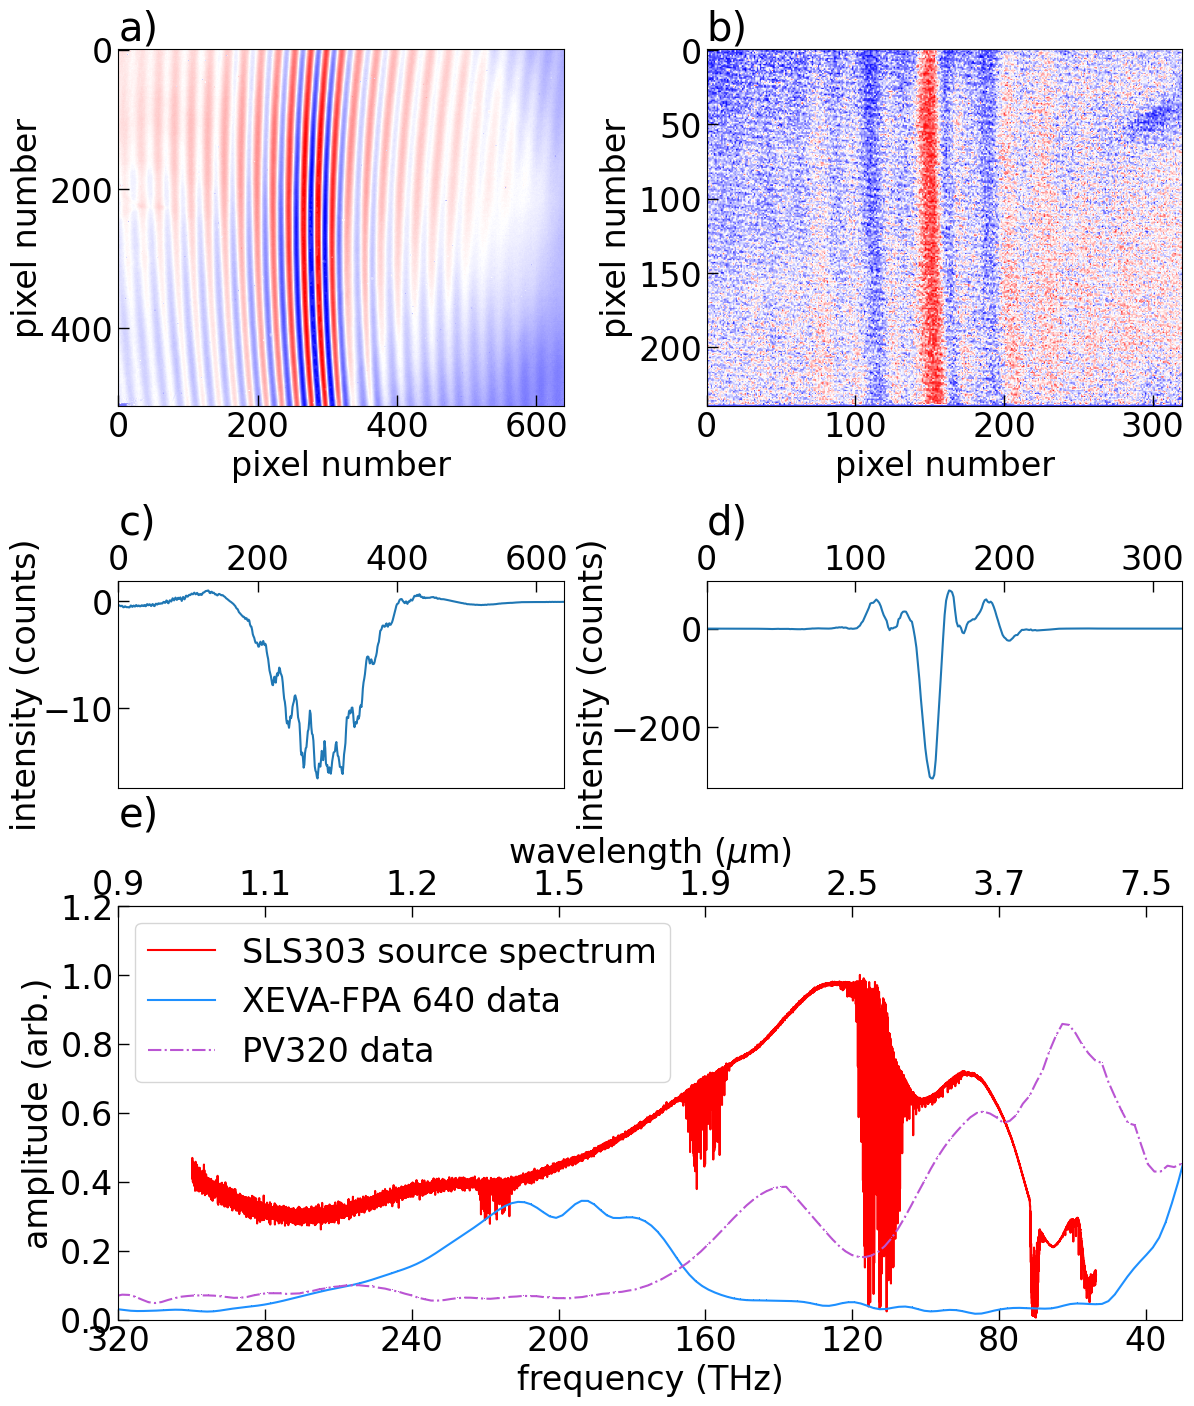

In [44]:
################BIG GRAPH##################

to_plot_purple_1d = FTIR.apodization(to_plot_purple_1d, purple_maximum, function= ["blackmann-harris"])
to_plot_xeva_1d = FTIR.apodization(to_plot_xeva_1d, xeva_maximum, function= ["blackmann-harris", "high pass"])

frequency_limits = [30,320] #THz

axs_mosaic = [["a)", "b)"],
              ["c)", "d)"],
              ["e)", "e)"]]

purple_aspect_ratio = to_plot_purple.shape[1] /to_plot_purple.shape[0]
xeva_aspect_ratio = to_plot_xeva.shape[1] /to_plot_xeva.shape[0]


plt.rcParams.update({'font.size':24})
fig, axs = plt.subplot_mosaic(axs_mosaic, figsize= (12,14), width_ratios= [xeva_aspect_ratio, purple_aspect_ratio], height_ratios= [1, 0.5, 1])

[ax.tick_params(direction= "in", length= 8, width= 1) for ax in axs.values()] #dictionary comprehention! Applies the function to every axis apart from secax.
[ax.set_title(label, loc='left') for label, ax in axs.items()] #Each `item` in a dictionary has a pair of `keys` and `values`. dict= {item1, item2, item3}. item1 = key1: value1
[ax.set_anchor("NW") for ax in axs.values()]

axs["a)"].imshow(to_plot_xeva, cmap='bwr')
axs["a)"].set(xlabel= "pixel number", ylabel= "pixel number")#, title= "Processed fringes on XEVA-FPA 640")

axs["c)"].plot(to_plot_xeva_1d)
axs["c)"].sharex(axs["a)"])
axs["c)"].tick_params(bottom= False, labelbottom= False, top= True, labeltop= True)
axs["c)"].set_ylabel("intensity (counts)", labelpad= 0)
axs["c)"].set(xlim= (0, to_plot_xeva.shape[1]))

axs["b)"].imshow(to_plot_purple, cmap='bwr')
axs["b)"].set(xlabel= "pixel number", ylabel= "pixel number")#, title= "Processed fringes on PV320")

axs["d)"].plot(to_plot_purple_1d)
axs["d)"].sharex(axs["b)"])
axs["d)"].tick_params(bottom= False, labelbottom= False, top= True, labeltop= True)
axs["d)"].set_ylabel("intensity (counts)", labelpad= 0)
axs["d)"].set(xlim= (0, to_plot_purple.shape[1]))

axs["e)"].plot(big_data[:,0],
                big_data[:,1],
                label = "SLS303 source spectrum",
                color = "red")
axs["e)"].plot(to_plot_xeva_freqs,
                to_plot_xeva_amps *0.7,
                label = "XEVA-FPA 640 data",
                color = "dodgerblue",
                linestyle = "-",
                marker= ",")
axs["e)"].plot(to_plot_purple_freqs,
                to_plot_purple_amps,
                label = "PV320 data",
                color = "mediumorchid",
                linestyle = "-.",
                marker= ",")

###customise axis
secax = axs["e)"].secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))

axs["e)"].set_xlabel('frequency (THz)')
axs["e)"].set_xticks([40,80,120,160,200,240,280,320])
secax.set_xlabel('wavelength ($\mu$m)')
secax.set_xticks(FTIR.recip(np.array([40,80,120,160,200,240,280,320])))
secax.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))
secax.tick_params(direction= "in", length= 8, width= 1) #secax in not a part of the axs dictionary so it didn't get the memo.

axs["e)"].set(ylabel= 'amplitude (arb.)', ylim= (0,1.2), xlim= frequency_limits[::-1])
axs["e)"].legend(loc= "upper left")

plt.tight_layout(pad= 0.2)
plt.show()

In [41]:
to_plot_xeva.shape

(512, 640)

In [42]:
to_plot_purple.shape

(240, 320)

In [43]:
to_plot_purple_freqs

array([   0.        ,    1.79200688,    3.58401377,    5.37602065,
          7.16802754,    8.96003442,   10.75204131,   12.54404819,
         14.33605508,   16.12806196,   17.92006884,   19.71207573,
         21.50408261,   23.2960895 ,   25.08809638,   26.88010327,
         28.67211015,   30.46411704,   32.25612392,   34.0481308 ,
         35.84013769,   37.63214457,   39.42415146,   41.21615834,
         43.00816523,   44.80017211,   46.59217899,   48.38418588,
         50.17619276,   51.96819965,   53.76020653,   55.55221342,
         57.3442203 ,   59.13622719,   60.92823407,   62.72024095,
         64.51224784,   66.30425472,   68.09626161,   69.88826849,
         71.68027538,   73.47228226,   75.26428915,   77.05629603,
         78.84830291,   80.6403098 ,   82.43231668,   84.22432357,
         86.01633045,   87.80833734,   89.60034422,   91.39235111,
         93.18435799,   94.97636487,   96.76837176,   98.56037864,
        100.35238553,  102.14439241,  103.9363993 ,  105.72840